<a href="https://colab.research.google.com/github/marioschlosser/rorschach/blob/main/Recursive_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Initialize OpenAI
!pip install openai
!pip install tiktoken
!pip install opencv-python

import openai
import tiktoken

from PIL import Image
from io import BytesIO
import requests
import random
import base64

openai_key = "" # @param {type:"string"}
openai.api_key = openai_key

tokenizer = tiktoken.encoding_for_model("gpt-4")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.2/220.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


In [ ]:
# image: PIL image to be described
# prompt: prompt to the vision model asking to describe the image
# index: number of recursion steps left

def recursive_rorschach(image, prompt, index):
  print("Step: ", index)

  image_bytes = BytesIO()
  image.save(image_bytes, format="png")
  base64_image = base64.b64encode(image_bytes.getvalue()).decode('utf-8')

  # get image description from GPT-4V
  response = openai.chat.completions.create(
      model="gpt-4-vision-preview",
      messages=[
          {
              "role": "user",
              "content": [
                  {"type": "text", "text": prompt},
                  {
                      "type": "image_url",
                      "image_url": { "url": f"data:image/jpeg;base64,{base64_image}" },
                  },
              ],
          }
      ],
      max_tokens=800,
  )

  # extract the image description
  prompt_image = response.choices[0].message.content

  print("Extracted prompt: ", prompt_image)

  # generate the replicated image
  response = openai.images.generate(
    model="dall-e-3",
    prompt=prompt_image,
    size="1024x1024",
    quality="standard",
    n=1,
  )

  # get the image
  image_url = response.data[0].url

  response = requests.get(image_url)
  new_image = Image.open(BytesIO(response.content))

  # stop the recursion if we're at the end
  if (index == 1):
    return [{"image": new_image, "prompt": prompt_image}]

  image_list = recursive_rorschach(new_image, prompt, index - 1)

  # insert the new image at the front of the list
  image_list.insert(0, {"image": new_image, "prompt": prompt_image})
  return image_list

In [ ]:
# @title Upload the initial image...

from google.colab import files
uploaded = files.upload()

img_bytes = list(uploaded.values())[0]
initial_image = Image.open(BytesIO(img_bytes))

Saving this_image.png to this_image (1).png
690168


In [ ]:
# @title ...Or create an initial image

prompt_initial_image = "A tiny, clean white dot in the corner of a uniform blue background." # @param {type:"string"}

# generate an image
response = openai.images.generate(
  model="dall-e-3",
  prompt=prompt_initial_image,
  size="1024x1024",
  quality="standard",
  n=1,
)

# get the image
image_url = response.data[0].url

response = requests.get(image_url)
initial_image = Image.open(BytesIO(response.content))

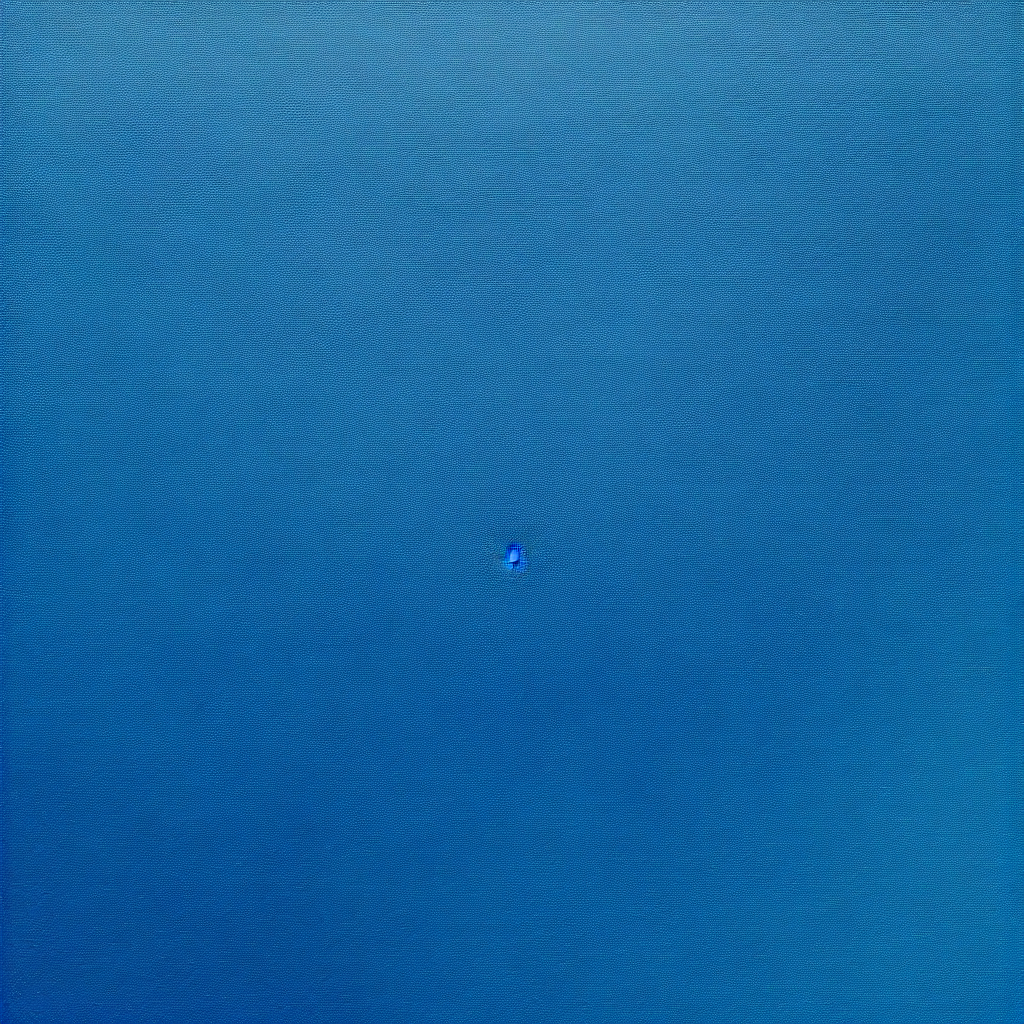

In [ ]:
# @title This is the initial image

initial_image

In [ ]:
# @title Run the Rorschach Recursion

prompt = "Describe in detail what you see in the image in 20 or fewer words." # @param {type:"string"}
num_iterations = 5 # @param {type:"integer"}

image_list = recursive_rorschach(initial_image, prompt, num_iterations)
image_list.insert(0, {"image": initial_image, "prompt": "(this is the initial image)"})

prompt_list = [image_dict['prompt'] for image_dict in image_list]

# save all images to disk
for i, image_dict in enumerate(image_list):
    image_dict['image'].save("image_{}.png".format(i))

# save all prompts to text file
with open('prompts.txt', 'w') as f:
    for prompt in prompt_list:
        f.write(prompt + '\n')

Step:  5
Extracted prompt:  A vast blue canvas with a small, indistinct white and blue object near the center.
Step:  4
Extracted prompt:  A celestial spiral galaxy surrounded by stars, nebula-like structures, and cosmic clouds in shades of blue and white.
Step:  3
Extracted prompt:  A vibrant illustration of various spiral galaxies amidst clouds of interstellar dust and stars.
Step:  2
Extracted prompt:  Artistic depiction of multiple swirling galaxies with stars in vibrant cosmic colors.
Step:  1
Extracted prompt:  Vivid cosmic image with multiple swirling galaxies, stars, and colorful nebulas against the backdrop of space.


In [ ]:
# @title Create the video from the generated images

import cv2
import numpy as np
import os
from google.colab import files

# Function to blend two images
def blend_images(image1, image2, alpha):
    return cv2.addWeighted(image1, alpha, image2, 1 - alpha, 0)

# Load your images (assuming they are in the 'images' folder and are named sequentially)
#image_files = [f'viterate_{i}.png' for i in range(num_iterations)]
#images = [cv2.imread(f'{file}') for file in image_files]
images = [cv2.cvtColor(np.array(pil_image['image']), cv2.COLOR_RGB2BGR) for pil_image in image_list]

# Specify the number of steps in the transition
transition_steps = 30

# Initialize video writer
frame_size = (images[0].shape[1], images[0].shape[0])
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('output_video.mp4', fourcc, 20.0, frame_size)

# Create transitions between images
for i in range(len(images) - 1):
    for step in range(int(transition_steps / 5)):
        video.write(images[i])

    # Cross-dissolve transition
    for step in range(transition_steps):
        alpha = step / transition_steps
        transition_image = blend_images(images[i + 1], images[i], alpha)
        video.write(transition_image)

# Make sure to write the last image
video.write(images[-1])

# Release the video writer
video.release()

# show download link for video
filename = 'output_video.mp4'
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title Download all images and prompts

import zipfile
import glob

# Create a list of all prompt txt files
prompt_files = glob.glob("prompts.txt")

# Create a list of all images
image_files = glob.glob("image_*.png")

# Create a zip file
with zipfile.ZipFile("output.zip", "w") as zip_file:
  # Add all prompt txt files to the zip file
  for prompt_file in prompt_files:
    zip_file.write(prompt_file)

  # Add all images to the zip file
  for image_file in image_files:
    zip_file.write(image_file)

# Make the zip file available for download
files.download("output.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>